### **1. Setup dan Import Library**

In [31]:
# Import library standar
import numpy as np
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import joblib

# Import untuk audio & ekstraksi fitur
import librosa
import tsfel
from tqdm import tqdm # Untuk progress bar yang rapi

# Import untuk Machine Learning (sklearn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA

# Mengatur agar plot tampil rapi dan warning tidak mengganggu
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("Semua library berhasil di-import.")

Semua library berhasil di-import.


### **2. Ekstraksi Fitur dari Dataset Audio**

In [32]:
# --- Konfigurasi TSFEL ---
try:
    cfg = tsfel.get_features_by_domain()
    N_FEATURES = len(cfg)
    print(f"TSFEL dikonfigurasi untuk mengekstrak {N_FEATURES} fitur.")
except Exception as e:
    print(f"Gagal memuat TSFEL: {e}")
    N_FEATURES = 0
    cfg = {}

# --- Path Dataset ---
# Menggunakan path relatif, pastikan folder 'data' sejajar dengan script Anda
DATASET_PATH = "data/dataset-audio"

# --- TAHAP 1: Kumpulkan daftar file ---
file_list = []
if N_FEATURES > 0:
    for root, dirs, files in os.walk(DATASET_PATH):
        for file_name in files:
            if file_name.endswith((".wav", ".mp3", ".flac")):
                file_path = os.path.join(root, file_name)
                parts = file_path.split(os.sep)
                command = parts[-2]
                person = parts[-3]
                label = f"{person}_{command}"
                file_list.append((file_path, label))
else:
    print("TSFEL tidak terkonfigurasi.")

# --- TAHAP 2: Ekstraksi fitur dengan TQDM & penangkap nama fitur ---
X_list = [] # List untuk fitur
y_list = [] # List untuk label
feature_names = None # Untuk menyimpan nama fitur TSFEL

if file_list:
    print(f"Ditemukan {len(file_list)} file. Memulai ekstraksi fitur...")
    
    # VISUALISASI: Progress bar TQDM
    for file_path, label in tqdm(file_list, desc="Mengekstrak Fitur"):
        try:
            y_audio, sr = librosa.load(file_path, sr=None)
            signal_df = pd.DataFrame({'signal': y_audio})
            
            # 'verbose=0' untuk mematikan progress bar internal tsfel
            features_df = tsfel.time_series_features_extractor(cfg, signal_df, fs=sr, verbose=0)
            
            # Ambil nama fitur (kolom) HANYA satu kali
            if feature_names is None:
                feature_names = features_df.columns.tolist()

            # Tambahkan fitur dan label
            X_list.append(features_df.values[0])
            y_list.append(label)

        except Exception as e:
            print(f"Gagal memproses {file_path}: {e}") # Lewati file yang error

    print(f"\nSelesai! {len(X_list)} sampel audio berhasil diekstrak.")
    if feature_names:
        print(f"Nama fitur berhasil ditangkap (Total: {len(feature_names)} nama).")
else:
    print("Tidak ada file yang ditemukan.")

TSFEL dikonfigurasi untuk mengekstrak 4 fitur.
Ditemukan 400 file. Memulai ekstraksi fitur...


Mengekstrak Fitur: 100%|██████████| 400/400 [02:02<00:00,  3.25it/s]


Selesai! 400 sampel audio berhasil diekstrak.
Nama fitur berhasil ditangkap (Total: 156 nama).


### **3. Persiapan Data dan Pembagian (Train/Test Split)**

In [33]:
X = np.array(X_list)
y = np.array(y_list)

# Cek hasil
if X.shape[0] > 0:
    print(f"\nBentuk data (X): {X.shape}") # (jumlah_sampel, 155)
    print(f"Bentuk label (y): {y.shape}")
    print(f"Kelas yang ditemukan: {np.unique(y)}")

    # Bagi data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y # Penting agar proporsi kelas seimbang
    )
    
    print("\nData berhasil dibagi:")
    print(f"Data Latih: {X_train.shape[0]} sampel")
    print(f"Data Uji: {X_test.shape[0]} sampel")
else:
    print("ERROR: Tidak ada data (X) untuk diproses. Cek Bagian 2.")


Bentuk data (X): (400, 156)
Bentuk label (y): (400,)
Kelas yang ditemukan: ['Abdi_buka' 'Abdi_tutup' 'Alex_buka' 'Alex_tutup']

Data berhasil dibagi:
Data Latih: 320 sampel
Data Uji: 80 sampel


### **4. Training dengan Keseluruhan Fitur**

In [34]:
print(f"\n--- EKSPERIMEN 1: Melatih dengan SEMUA {N_FEATURES} FITUR TSFEL ---")

# 1. Scaling data
print("Melakukan scaling data...")
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train)
X_test_scaled_all = scaler_all.transform(X_test)

# 2. Latih model
print("Melatih model 'model_all_features'...")
model_all_features = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_all_features.fit(X_train_scaled_all, y_train)

# 3. Prediksi dan hitung akurasi
y_pred_all = model_all_features.predict(X_test_scaled_all)
acc_all_features = accuracy_score(y_test, y_pred_all)

print(f"Hasil Akurasi (Semua Fitur): {acc_all_features * 100:.2f}%")


--- EKSPERIMEN 1: Melatih dengan SEMUA 4 FITUR TSFEL ---
Melakukan scaling data...
Melatih model 'model_all_features'...
Hasil Akurasi (Semua Fitur): 96.25%


### **5. Seleksi Fitur (Information Gain)**

In [35]:
print(f"\n--- EKSPERIMEN 2: Mencari 'k' Fitur Terbaik ---")
print("Langkah 5a: Menghitung ranking fitur (Information Gain)...")

# --- PERUBAHAN 1: Tentukan threshold ---
threshold = 0.5
print(f"Menggunakan threshold Information Gain: {threshold}")

# Hitung skor IG pada data latih (non-scaled)
feature_scores = mutual_info_classif(X_train, y_train)

# --- MEMBUAT DAFTAR PERINGKAT ---
# Gabungkan nama fitur dan skor
combined_features = list(zip(feature_scores, feature_names))

# --- PERUBAHAN 2: Filter yang skornya >= threshold ---
filtered_features = [item for item in combined_features if item[0] >= threshold]
sorted_features = sorted(filtered_features, key=lambda x: x[0], reverse=True)
# ------------------------------

# --- MEMFILTER DATA UNTUK LOOPING (Bagian 5c) ---
# --- PERUBAHAN 2: Gunakan threshold untuk mask ---
fitur_penting_mask = feature_scores >= threshold
X_train_filtered = X_train[:, fitur_penting_mask]
X_test_filtered = X_test[:, fitur_penting_mask]

max_features_to_test = X_train_filtered.shape[1]
fitur_dihapus = X.shape[1] - max_features_to_test

print(f"Fitur asli: {X.shape[1]}")
print(f"Fitur dihapus (skor < {threshold}): {fitur_dihapus}")
print(f"Sisa fitur untuk diuji: {max_features_to_test}")

# Scaling data yang SUDAH difilter
print("Melakukan scaling pada data yang sudah difilter...")
scaler_loop = StandardScaler()
X_train_loop_scaled = scaler_loop.fit_transform(X_train_filtered)
X_test_loop_scaled = scaler_loop.transform(X_test_filtered)

# --- (Bagian 5b) Menampilkan Daftar Peringkat Fitur ---
print("\n" + "="*70)
print(f"Langkah 5b: Daftar Peringkat Fitur (Skor IG >= {threshold})")
print("="*70)
print(f"{'Peringkat':<10} | {'Skor IG':<15} | {'Nama Fitur'}")
print("-" * 70)

# --- PERUBAHAN 3: Tampilkan KESELURUHAN list ranking ---
if sorted_features:
    for i, (score, name) in enumerate(sorted_features):
        print(f"{i+1:<10} | {score:<15.6f} | {name}")
else:
    print(f"Tidak ada fitur yang memiliki skor >= {threshold}.")

print("-" * 70)
print(f"Total {len(sorted_features)} fitur memiliki skor >= {threshold}.")


--- EKSPERIMEN 2: Mencari 'k' Fitur Terbaik ---
Langkah 5a: Menghitung ranking fitur (Information Gain)...
Menggunakan threshold Information Gain: 0.5
Fitur asli: 156
Fitur dihapus (skor < 0.5): 77
Sisa fitur untuk diuji: 79
Melakukan scaling pada data yang sudah difilter...

Langkah 5b: Daftar Peringkat Fitur (Skor IG >= 0.5)
Peringkat  | Skor IG         | Nama Fitur
----------------------------------------------------------------------
1          | 0.942928        | signal_Spectrogram mean coefficient_13161.29Hz
2          | 0.889544        | signal_Neighbourhood peaks
3          | 0.844954        | signal_Signal distance
4          | 0.823485        | signal_ECDF_8
5          | 0.822007        | signal_ECDF_2
6          | 0.819186        | signal_ECDF_4
7          | 0.817453        | signal_ECDF Percentile Count_1
8          | 0.816464        | signal_ECDF_3
9          | 0.810008        | signal_Wavelet variance_12000.0Hz
10         | 0.809966        | signal_ECDF Percentile Count_

In [36]:
print(f"\nLangkah 5c: Memulai looping untuk mencari k terbaik (1 s/d {max_features_to_test})...")

accuracies_loop = []
k_values = range(1, max_features_to_test + 1)

for k in tqdm(k_values, desc="Menguji Jumlah Fitur (k)"):
    # 1. Pilih k fitur terbaik
    selector_loop = SelectKBest(score_func=mutual_info_classif, k=k)
    selector_loop.fit(X_train_filtered, y_train) # Fit pada data non-scaled
    
    # 2. Terapkan (transform) selector ke data yang SUDAH di-scaling
    X_train_k = selector_loop.transform(X_train_loop_scaled)
    X_test_k = selector_loop.transform(X_test_loop_scaled)
    
    # 3. Latih model (n_estimators lebih kecil agar loop cepat)
    model_loop = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_loop.fit(X_train_k, y_train)
    
    # 4. Prediksi dan simpan akurasi
    acc_k = accuracy_score(y_test, model_loop.predict(X_test_k))
    accuracies_loop.append(acc_k)

print("Looping selesai.")

# Cari hasil terbaik
best_k_index = np.argmax(accuracies_loop)
best_k = k_values[best_k_index]
best_acc_loop = accuracies_loop[best_k_index]

print(f"\n--- Hasil Looping Seleksi Fitur ---")
print(f"Akurasi tertinggi adalah {best_acc_loop * 100:.2f}%")
print(f"Didapatkan saat menggunakan {best_k} fitur terbaik.")


Langkah 5c: Memulai looping untuk mencari k terbaik (1 s/d 79)...


Menguji Jumlah Fitur (k):   0%|          | 0/79 [00:00<?, ?it/s]

Menguji Jumlah Fitur (k): 100%|██████████| 79/79 [00:28<00:00,  2.75it/s]

Looping selesai.

--- Hasil Looping Seleksi Fitur ---
Akurasi tertinggi adalah 96.25%
Didapatkan saat menggunakan 25 fitur terbaik.


Langkah 5d: Visualisasi Hasil Looping 'k'...


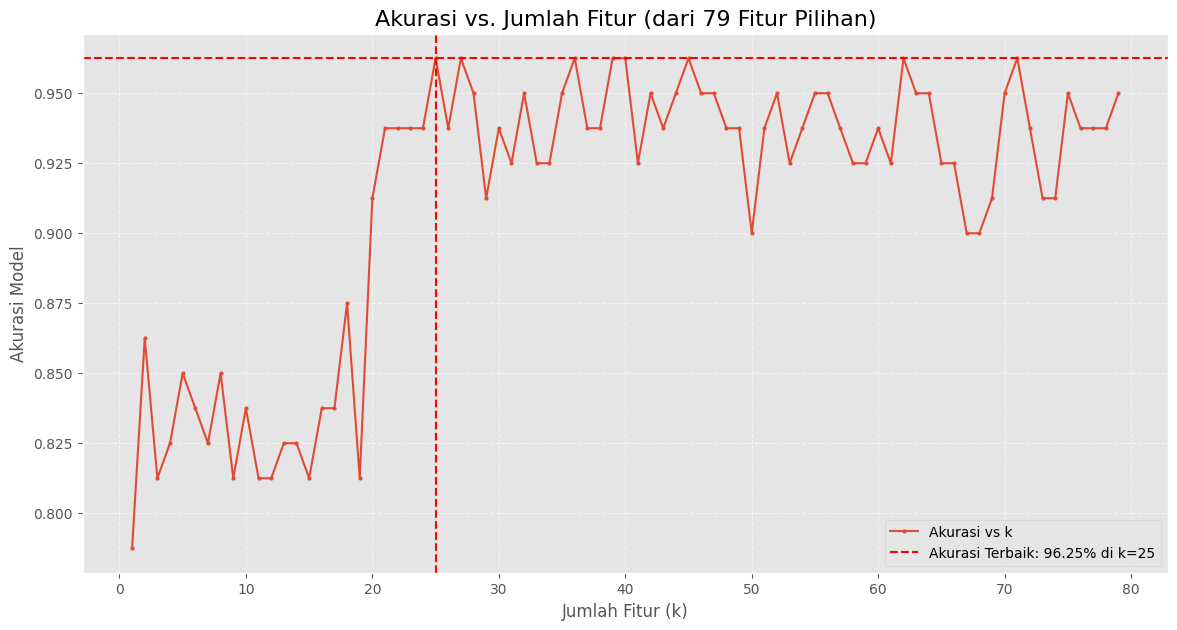

In [37]:
print("Langkah 5d: Visualisasi Hasil Looping 'k'...")

plt.figure(figsize=(14, 7))
plt.plot(k_values, accuracies_loop, marker='.', linestyle='-', markersize=4, label='Akurasi vs k')
plt.title(f'Akurasi vs. Jumlah Fitur (dari {max_features_to_test} Fitur Pilihan)', fontsize=16)
plt.xlabel('Jumlah Fitur (k)', fontsize=12)
plt.ylabel('Akurasi Model', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Beri tanda pada akurasi terbaik
plt.axvline(x=best_k, color='red', linestyle='--', 
            label=f'Akurasi Terbaik: {best_acc_loop*100:.2f}% di k={best_k}')
plt.axhline(y=best_acc_loop, color='red', linestyle='--')
plt.legend(loc='best') # Menampilkan label 'Akurasi Terbaik'

plt.show()

### **6. Transformasi dengan PCA**

In [38]:
print(f"\n--- EKSPERIMEN 3: Melatih dengan TRANSFORMASI PCA ---")

# Kita samakan jumlah komponennya dengan 'best_k' agar adil
n_components_pca = best_k 

# Cek jika best_k = 0 (tidak ada fitur lolos threshold)
if n_components_pca == 0:
    print("PCA dilewati karena best_k = 0.")
    acc_pca = 0.0
else:
    print(f"Mereduksi SEMUA {N_FEATURES} fitur menjadi {n_components_pca} komponen PCA...")

    # 1. Buat dan fit PCA (pada data scaled dari Eksperimen 1)
    pca = PCA(n_components=n_components_pca, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled_all) # <-- Menggunakan data LENGKAP
    X_test_pca = pca.transform(X_test_scaled_all) # <-- Menggunakan data LENGKAP

    print(f"Bentuk data setelah PCA: {X_train_pca.shape}")

    # 2. Latih model BARU
    print("Melatih model 'model_pca'...")
    model_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model_pca.fit(X_train_pca, y_train)

    # 3. Prediksi dan hitung akurasi
    y_pred_pca = model_pca.predict(X_test_pca)
    acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"Hasil Akurasi (PCA - {n_components_pca} Komponen): {acc_pca * 100:.2f}%")


--- EKSPERIMEN 3: Melatih dengan TRANSFORMASI PCA ---
Mereduksi SEMUA 4 fitur menjadi 25 komponen PCA...
Bentuk data setelah PCA: (320, 25)
Melatih model 'model_pca'...
Hasil Akurasi (PCA - 25 Komponen): 92.50%


Langkah 6b: Visualisasi Cumulative Explained Variance PCA...


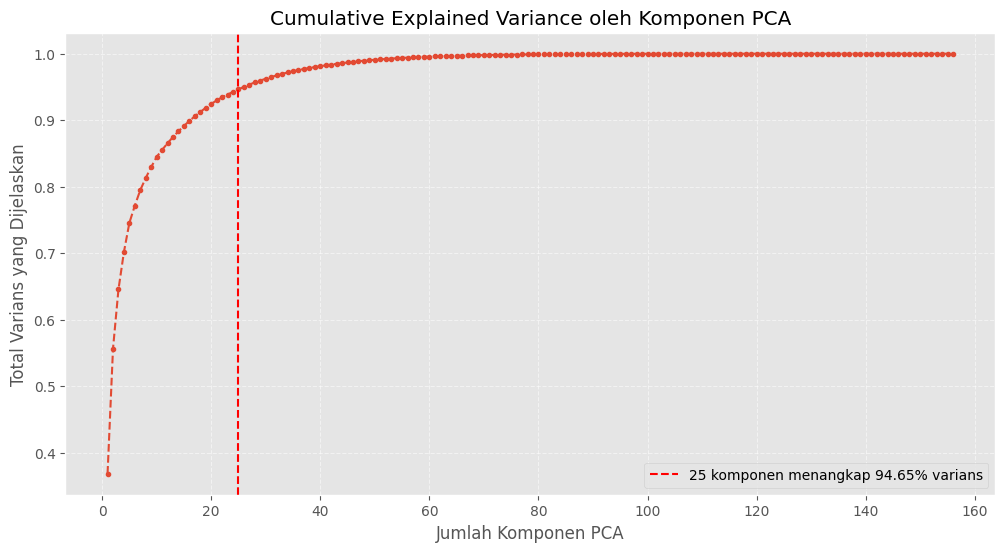

In [39]:
print("Langkah 6b: Visualisasi Cumulative Explained Variance PCA...")

# Kita fit PCA baru (tanpa batas komponen) untuk melihat sebaran varians
pca_plot = PCA(n_components=None, random_state=42)
pca_plot.fit(X_train_scaled_all) # <-- Menggunakan data LENGKAP

# Hitung kumulatif varians
cumulative_variance = np.cumsum(pca_plot.explained_variance_ratio_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--')
plt.title('Cumulative Explained Variance oleh Komponen PCA')
plt.xlabel('Jumlah Komponen PCA')
plt.ylabel('Total Varians yang Dijelaskan')
plt.grid(True, linestyle='--', alpha=0.5)

# Tandai di mana 'n' yang kita pilih berada
if n_components_pca > 0:
    plt.axvline(x=n_components_pca, color='red', linestyle='--', 
                label=f'{n_components_pca} komponen menangkap {cumulative_variance[n_components_pca-1]*100:.2f}% varians')
    plt.legend(loc='best')
    
plt.show()

### **7. Ringkasan Akhir dan Visualisasi Perbandingan**


RINGKASAN AKHIR HASIL EKSPERIMEN
Eksperimen 1 (Semua 4 Fitur): 		96.25%
Eksperimen 2 (Seleksi Fitur Terbaik): 	96.25% (menggunakan 25 fitur)
Eksperimen 3 (Transformasi PCA): 		92.50% (menggunakan 25 komponen)

Langkah 7b: Visualisasi Perbandingan Hasil Akhir...


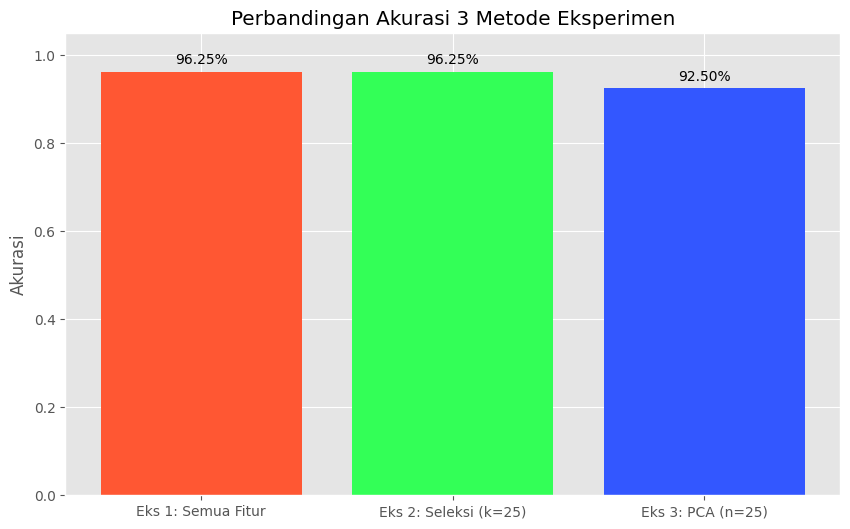

In [40]:
print("\n" + "="*50)
print("RINGKASAN AKHIR HASIL EKSPERIMEN")
print("="*50)
print(f"Eksperimen 1 (Semua {N_FEATURES} Fitur): \t\t{acc_all_features * 100:.2f}%")
print(f"Eksperimen 2 (Seleksi Fitur Terbaik): \t{best_acc_loop * 100:.2f}% (menggunakan {best_k} fitur)")
print(f"Eksperimen 3 (Transformasi PCA): \t\t{acc_pca * 100:.2f}% (menggunakan {n_components_pca} komponen)")
print("="*50)

# --- Visualisasi Perbandingan Hasil Akhir ---
print("\nLangkah 7b: Visualisasi Perbandingan Hasil Akhir...")

labels = ['Eks 1: Semua Fitur', f'Eks 2: Seleksi (k={best_k})', f'Eks 3: PCA (n={n_components_pca})']
accuracies = [acc_all_features, best_acc_loop, acc_pca]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=['#FF5733', '#33FF57', '#3357FF'])
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi 3 Metode Eksperimen')
plt.ylim(0, 1.05) # Batas y dari 0% sampai 105%

# Tambahkan label angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval*100:.2f}%', ha='center', va='bottom')

plt.show()

In [41]:
# (Variabel ini seharusnya sudah ada dari cell sebelumnya)
print(f"Menggunakan 'k' terbaik yang ditemukan: {best_k}")

# Ambil 'best_k' nama fitur teratas dari daftar peringkat And
selected_feature_names = [name for score, name in sorted_features[:best_k]]
print(f"Daftar {len(selected_feature_names)} fitur terbaik telah disiapkan.")

# -----------------------------------------------------------------
# 2. PERSIAPKAN DATA FINAL UNTUK TRAINING
# -----------------------------------------------------------------
# Buat DataFrame dari X_train agar kita bisa memilih berdasarkan nama
# (feature_names didapat dari Cell 2 saat ekstraksi TSFEL)
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Pilih HANYA fitur-fitur terbaik
X_train_final = X_train_df[selected_feature_names]

print(f"Bentuk data latih final: {X_train_final.shape}")

# -----------------------------------------------------------------
# 3. LATIH SCALER & MODEL FINAL
# -----------------------------------------------------------------
# Buat dan latih scaler BARU HANYA pada data final
final_scaler = StandardScaler()
X_train_final_scaled = final_scaler.fit_transform(X_train_final)
print("Scaler final telah dilatih.")

# Latih model final dengan data yang sudah dipilih dan di-scale
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_train_final_scaled, y_train)
print("Model final telah dilatih.")


joblib.dump(final_model, 'model_final.joblib')
joblib.dump(final_scaler, 'scaler_final.joblib')
joblib.dump(selected_feature_names, 'selected_feature_names.pkl')

print("\nBerhasil! Model, scaler, dan daftar fitur telah disimpan ke file:")
print("- model_final.joblib")
print("- scaler_final.joblib")
print("- selected_feature_names.pkl")

Menggunakan 'k' terbaik yang ditemukan: 25
Daftar 25 fitur terbaik telah disiapkan.
Bentuk data latih final: (320, 25)
Scaler final telah dilatih.
Model final telah dilatih.

Berhasil! Model, scaler, dan daftar fitur telah disimpan ke file:
- model_final.joblib
- scaler_final.joblib
- selected_feature_names.pkl


In [42]:
# --- 1. Ambil k terbaik (sesuai hasil Cell 6) ---
best_k = 25 
print(f"Menggunakan k = {best_k} fitur terbaik (sesuai notebook).")

# Ambil NAMA dari {best_k} fitur teratas
# (sorted_features sudah ada di memori dari Cell 5)
selected_feature_names = [name for score, name in sorted_features[:best_k]]
print(f"Daftar {len(selected_feature_names)} fitur terbaik telah disiapkan.")

# --- 2. Persiapan Data Final (Menggunakan 'X' dan 'y' dari Cell 3) ---
print("Mempersiapkan data final untuk pelatihan...")

# Buat DataFrame dari X (SEMUA data) agar bisa memilih berdasarkan nama
# (X dan feature_names sudah ada di memori)
X_df = pd.DataFrame(X, columns=feature_names)

# Pilih HANYA fitur-fitur terbaik
X_final_selected = X_df[selected_feature_names]

print(f"Bentuk data latih final: {X_final_selected.shape}")

# --- 3. Latih Scaler & Model FINAL ---
# Latih scaler HANYA pada 25 fitur ini
scaler_final = StandardScaler()
X_final_scaled = scaler_final.fit_transform(X_final_selected)
print("Scaler final telah dilatih.")

# Latih model final pada SEMUA data
model_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_final.fit(X_final_scaled, y)
print("Model final telah dilatih.")

# --- 4. HITUNG AKURASI TRAINING (TAMBAHAN) ---
print("Menghitung akurasi training...")
y_pred_train = model_final.predict(X_final_scaled)
train_accuracy = accuracy_score(y, y_pred_train)
print(f"Akurasi Training (pada {len(y)} data): {train_accuracy * 100:.2f}%")
# -----------------------------------------------

# --- 5. Simpan Artefak (untuk app.py) ---
artifacts = {
    'tsfel_cfg': cfg,                          # Konfigurasi TSFEL
    'feature_names': feature_names,            # Daftar SEMUA 156 nama
    'selected_feature_names': selected_feature_names, # Daftar 25 nama TERBAIK
    'scaler': scaler_final,                    # Scaler yang dilatih pada 25 fitur
    'model': model_final,                      # Model yang dilatih pada 25 fitur
    'labels': model_final.classes_
}

output_filename = 'model_artifacts.joblib'
joblib.dump(artifacts, output_filename)

print(f"\nModel dan artefak baru berhasil disimpan ke: {output_filename}")

Menggunakan k = 25 fitur terbaik (sesuai notebook).
Daftar 25 fitur terbaik telah disiapkan.
Mempersiapkan data final untuk pelatihan...
Bentuk data latih final: (400, 25)
Scaler final telah dilatih.
Model final telah dilatih.
Menghitung akurasi training...
Akurasi Training (pada 400 data): 100.00%

Model dan artefak baru berhasil disimpan ke: model_artifacts.joblib
